<a href="https://colab.research.google.com/github/scardenol/ai_2023/blob/main/3.%20Unsupervised/entrega_Salo/src/density_and_distance_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Load required libraries

In [1]:
# Install UMAP library
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=c2c71e38697bce12893e91e021ba8855683186cfc95d92cb73f3ce9c0d396c62
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=974dd776798c161a558a264477dcb0242b8ab066ae837e5abedaf50514303731
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
import umap
import pandas as pd
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import functools

# UMAP for non-linear dimensionality reduction

The Uniform Manifold Approximation and Projection (UMAP) is a non-linear dimensionality reduction algorithm used for visualizing and clustering high-dimensional data. It works by preserving the local structure of the data while optimizing a low-dimensional representation that is easier to visualize and analyze.

## Example on iris data set

In [3]:
# Load the data
iris = sns.load_dataset('iris')
X = iris.drop('species', axis=1)

In [4]:
def normalize_data(X):
    """ Normalize data to be between 0 and 1.
    Args:
        X (_np.array_): the data to be normalized.
    Returns:
        _np.array_: the normalized data.
    """
    X = X - np.min(X, axis=0)
    X = X / np.max(X, axis=0)
    return X


In [5]:
# Normalize data to the hypercube [0,1]
X = normalize_data(X)
iris.iloc[:,:-1] = X

In [6]:
# Fit the UMAP model and transform the data. Embed the data to a 2D space (n_components)
reducer = umap.UMAP(n_components=2, metric="euclidean", min_dist=0.3, n_neighbors=5)
embedding = reducer.fit_transform(X)

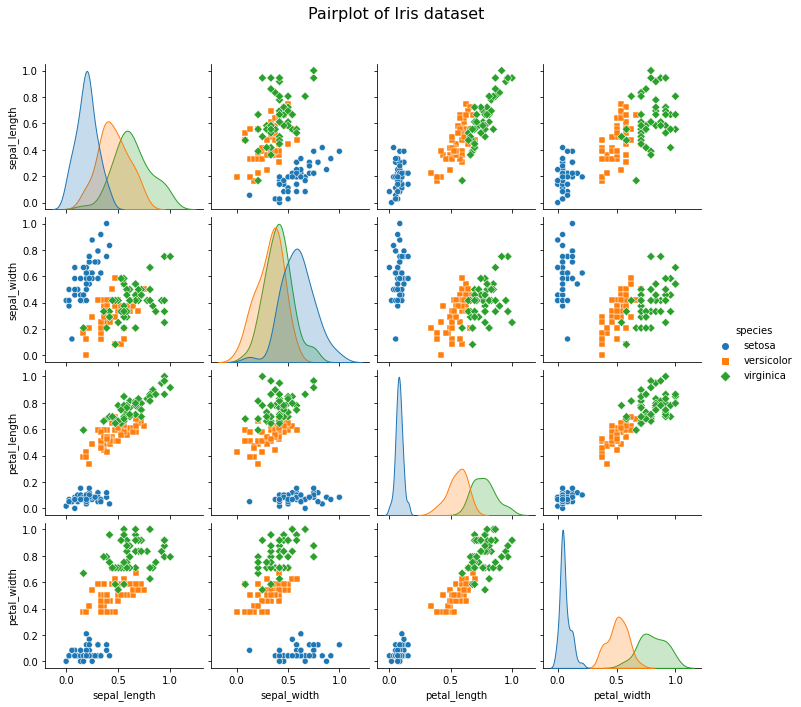

In [7]:
# Plot the original data set
g = sns.pairplot(data=iris, hue='species', markers=["o", "s", "D"]);
g.fig.suptitle("Pairplot of Iris dataset", size=16)
g.figure.subplots_adjust(top=.9)

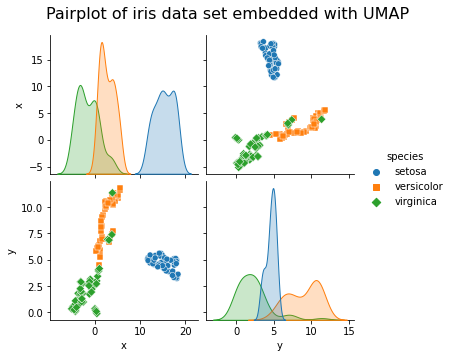

In [8]:
# Plot the reduced data in 2D
embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
embedding_df['species'] = iris['species']
g = sns.pairplot(data=embedding_df, hue='species', markers=["o", "s", "D"])
g.fig.suptitle("Pairplot of iris data set embedded with UMAP", size=16)
g.figure.subplots_adjust(top=.9)

# Clustering algorithms




In this section we focus on the implementation of density-based and distance-based clustering algorithms and provide an example with the iris data set ("toy data") for each algorithm. The algorithms are:


**Density-based**
1. Mountain
2. Substractive
**Distance-based**
3. $k$-means
4. fuzzy $c$-means

### Auxiliary functions



In [9]:
# Plot data in 2D and 3D

def plot_data(X, Y, labels, colors=None, hold_on=False):
    """ Plot the data with colored labels and legend.
    Args:
        X (_np.array_): the data to be plotted.
        Y (_np.array_): the labels of the data.
        labels (_list_): the labels of the data.
        colors (_list_): the colors to be used for the data.
        hold_on (_bool_): whether to hold on to the current plot or not.
    """
    if not hold_on:
        plt.figure(figsize=(8, 6))
    if colors is not None:
        color = itertools.cycle(colors)
    for i in range(len(labels)):
        x, y = X[Y==i, 0], X[Y==i, 1]
        if colors is None:
            plt.scatter(x, y, label=labels[i])
        else:
            plt.scatter(x, y, label=labels[i], color=next(color))
    plt.legend()
    if not hold_on:
        plt.show()

# Plot the data in 3D
def plot_data_3d(X, Y, labels, colors=None, hold_on=False, ax=None):
    """ Plot the data in 3D.
    Args:
        X (_np.array_): the data to be plotted.
        Y (_np.array_): the labels of the data.
        labels (_list_): the labels of the data.
        colors (_list_): the colors to be used for the data.
        hold_on (_bool_): whether to hold on to the current plot or not.
        ax (_matplotlib.axes.Axes_): the axes to plot on.
    Raises:
        ValueError: if hold_on is True and ax is None.
    """
    if not hold_on:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    elif ax is None:
        raise ValueError('If hold_on is True, then ax must be provided')
    else:
        ax = ax
    if colors is not None:
        color = itertools.cycle(colors)
    for i in range(len(labels)):
        x, y, z = X[Y==i, 0], X[Y==i, 1], X[Y==i, 2]
        if colors is None:
            ax.scatter(x, y, z, label=labels[i])
        else:
            ax.scatter(x, y, z, label=labels[i], color=next(color))
    if not hold_on:
        plt.show()

In [10]:
# Create and plot grid space

def create_grid_space(granularity=100, dimensions=2):
    """Create a grid space of points that can be used to color the points in the data set.
    Args:
        granularity (_int_): the number of points in each dimension of the grid space.
        dimensions (_int_): the number of dimensions of the grid space.
    Returns:
        _np.array_: a numpy array containing the grid space points or coordinates.
    """
    grid_space = np.meshgrid(*[np.linspace(0, 1, granularity) for _ in range(dimensions)])
    grid_space = np.array([x.flatten() for x in grid_space]).T
    return grid_space

def plot_grid_space(grid_space, hold_on=False, ax=None):
    """Plot the grid space. If the number of dimensions is 2, then plot the grid space as a scatter plot.
    If the  number of dimensions is 3, then plot the grid space as a 3D scatter plot. If the number of
    dimensions is greater than 3, then plot the grid space as a 2D scatter plot with the first two dimensions.
    If the number of dimensions is 1, then plot the grid space as points.
    Args:
        grid_space (_np.array_): the grid space to be plotted.
        hold_on (_bool_): whether to hold on to the current plot or not.
        ax (_matplotlib.axes.Axes_): the axes to plot on.
    """
    if not hold_on:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    elif grid_space.shape[1] >= 3 and ax is None:
        raise ValueError('If hold_on is True for spaces >= 3D, then ax must be provided')
    else:    
        ax = ax
    if (
        grid_space.shape[1] == 2
    ):
        plt.scatter(grid_space[:, 0], grid_space[:, 1], label='grid space')
    elif grid_space.shape[1] >= 3:
        ax.scatter(grid_space[:, 0], grid_space[:, 1], grid_space[:, 2], label='grid space')
    elif grid_space.shape[1] == 1:
        plt.scatter(grid_space[:, 0], np.zeros(grid_space.shape[0]), label='grid space')
    if not hold_on:
        plt.legend()
        plt.show()

def plot_gridAndData(grid_space, with_data=False, X=None, Y=None, labels=None):
    """ Plot the grid space and the data.
    Args:
        grid_space (_np.array_): the grid space to be plotted.
        with_data (_bool_): whether to plot the data or not.
        X (_np.array_): the data to be plotted.
        Y (_np.array_): the labels of the data.
        labels (_list_): the labels of the data.
    """
    fig = plt.figure(figsize=(8, 6))
    if with_data:
        X, Y, labels = X, Y, labels
    if grid_space.shape[1] >= 3 and X.shape[1] >= 3:
        ax = fig.add_subplot(111, projection='3d')
        plot_grid_space(grid_space, hold_on=True, ax=ax)
        if with_data:
            plot_data_3d(X, Y, labels, hold_on=True, ax=ax)
    else:
        ax = fig.add_subplot(111, projection=None)
        plot_grid_space(grid_space, hold_on=True)
        if with_data:
            plot_data(X, Y, labels, hold_on=True)
    plt.legend()
    plt.show()
    

In [11]:
# Functions to visualize results
# Function to gather results in a data frame
def results2df(data, names, Y_hat, C):
    """ Gather results in a data frame. This function concatenates the data with the predicted labels and the
    centers of the clusters. The data frame is then sorted by cluster number.
    
    Args:
        data (pd.DataFrame): the data to be clustered.
        names (list): the list of feature names.
        Y_hat (np.array): the predicted labels.
        C (np.array): the centers of the clusters.
    
    Returns:
        pd.DataFrame: the data frame with the data, the predicted labels, and the centers of the clusters.
    """
    # Concatenate data with predicted labels
    results_df = np.concatenate([data.values, np.expand_dims(Y_hat, axis=1)], axis=1)

    # Convert to data frame
    results_df = pd.DataFrame(results_df, columns=[*names, "cluster"])

    # Convert cluster column to string
    results_df['cluster'] = results_df['cluster'].astype(int)
    results_df['cluster'] = results_df['cluster'].astype(str)

    # Add "cluster" to each cluster number
    results_df['cluster'] = "cluster " + results_df['cluster']

    # Sort by cluster column
    results_df = results_df.sort_values(by=["cluster"])

    # Create temporary center data frame to be merged
    centers_df = pd.DataFrame(C)

    # Define label for centers
    centers_df["cluster"] = "center"

    # Rename columns so both data frames match
    centers_df.columns = results_df.columns

    # Concatenate data frames into a single one
    results_df = pd.concat([results_df, centers_df], axis=0, ignore_index=True)
    
    return results_df

# 2D and 3D scatter plots with plotly
def plotly_scatter(df, names, plot_type="2D", color=None, title=None, color_discrete_sequence=None, opacity=1):
    """ Create a 2D or 3D scatter plot with plotly.
    
    Args:
        df (pd.DataFrame): the data to be plotted.
        names (list): the list of feature names.
        plot_type (str): the type of plot, must be "2D" or "3D".
        color (str): the name of the column to be used as color.
        title (str): the title of the plot.
        color_discrete_sequence (list): the list of colors to be used.
        opacity (float): the opacity of the points.
        
    Returns:
        None
    """
    if color_discrete_sequence == None:
        color_discrete_sequence = [*list(range(len(df.iloc[:,-1].unique())-1)),"black"]
    if plot_type=="2D":
      fig = px.scatter(data_frame=df, x=names[0], y=names[1], color=color,
                         title=title, color_discrete_sequence=color_discrete_sequence)
    elif plot_type=="3D":
      fig = px.scatter_3d(data_frame=df, x=names[0], y=names[1], z=names[2],
                            color=color, title=title, color_discrete_sequence=color_discrete_sequence)
    else:
        raise ValueError("Invalid plot_type muste be ""2D"" or ""3D"".")
    fig.update_traces(opacity=opacity)
    fig.show()

In [12]:
# Transform membership matrix into cluster labels.
def membership_to_labels(membership):
    """ Transform membership matrix into cluster labels.
    
    Args:
        membership (np.array): the membership matrix.
        
    Returns:
        np.array: the resulting cluster labels.
    """
    return np.argmax(membership, axis=1)

## Distance function
We consider 4 distance norms: Manhattan, Euclidean, Mahalanobis and Cosine.

In [13]:
def distance(x, y, dist_type):
    """Distance function.
    
    Args:
        x (np.array): the first point.
        y (np.array): the second point.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
    
    Returns:
        float: the distance between the two n-dimensional points or vectors.
    """
    if dist_type == 1:
        return np.sum(np.abs(x - y))
    elif dist_type == 2:
        return np.sqrt(np.sum((x - y) ** 2))
    elif dist_type == "mahal":
        return np.sqrt((x-y).T @ np.linalg.inv(np.cov(x)) @ (x-y))
    elif dist_type == "cos":
        return 1 - np.dot(x, y) / (np.sqrt(np.sum(x ** 2)) * np.sqrt(np.sum(y ** 2)))
    else:
        raise ValueError("Invalid distance type.")

## Mountain

In [96]:
def mountain_clustering(X, granularity=2, sigma=0.2, beta=None, dist_type=2, verbose=False):
    """A clustering algorithm that uses a mountain matrix to cluster data.

    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        granularity (_int_): the granularity of the grid space, i.e., the number of points in each dimension.
        K (_int_): the number of clusters.
        sigma (_float_): the height and the smoothing of the mountain function. Is an application specific parameter, that
        acts as the kernel influence or bandwidth for the mountain function construction and update.
        beta (_float_, optional): the height and the smoothing of the updated mountain function. Defaults to None, as it
        is internally defined as 2*sigma.
        dist_type (_int_, optional): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine. Defaults to 2.
        verbose (_bool_, optional): whether to print the progress of the algorithm. Defaults to True.

    Returns:
        _tuple_: a tuple containing the cluster centers, the resulting cluster labels and the mountain matrix.
    """
    if beta is None:
        beta = 2*sigma

    num_obs, num_features = X.shape
    num_grid_points = granularity**num_features
    
    # Assume a big fixed number of clusters
    K = 100

    # Create grid space (array where each row is a point in the grid space or a tuple of coordinates)
    grid_space = create_grid_space(granularity=granularity, dimensions=num_features)
    # Initialize mountain matrix and mountain centers
    M = np.zeros(num_grid_points)
    M_centers = np.zeros(K)
    # Initialize cluster centers
    C = np.zeros(shape=(K, num_features))
    C_idx = np.zeros(K).astype(int)

    # Calculate the mountain matrix for the remaining cluster centers (except the first one)
    cluster = 0
    while True:
        if verbose:
            print(f'Calculating cluster center {cluster}...')
        for i, point in enumerate(grid_space):
            for j in range(num_obs):
                if cluster == 0:
                    M[i] += np.exp(-distance(point, X[j,:], dist_type)**2 / (2*sigma**2))
                else:
                    M[i] = M[i] - M[C_idx[cluster-1]]*np.exp(-distance(point, C[cluster-1], dist_type)**2 / (2*beta**2))
        
        # Get index of maximum value in mountain matrix
        C_idx[cluster] = int(np.argmax(M))
        # Set current cluster as the maximum value in mountain matrix
        new_center = grid_space[C_idx[cluster], :]
        
        # Stop criteria Check if the new center is already in the list of centers or if the mountain value is too small.
        if ( np.any(np.equal(C, new_center).all(axis=1)) ) or (
            M[C_idx[cluster]] < min(1e-3, 0.5/(granularity-1))
        ):
            C = C[:cluster, :]
            C_idx = C_idx[:cluster]
            M_centers = M_centers[:cluster]
            if verbose:
                print(f'Number of clusters found: {cluster} \n with points {C}')
            break
        
        # Update the cluster centers and mountain centers
        C[cluster, :] = new_center
        M_centers[cluster] = M[C_idx[cluster]]
        
        # Print the current cluster center and mountain center value
        if verbose:
            print(f'Cluster center {cluster} : {C[cluster]}')
            print(f'Mountain center value {M_centers[cluster]}')
        
        # Advance to the next cluster
        cluster += 1

    # Calculate which points are within each cluster
    Y_hat = np.zeros(num_obs)
    Y_hat = np.argmin(np.linalg.norm(X[:, np.newaxis, :] - C[np.newaxis, :, :], axis=2), axis=1)
    return C, Y_hat, M

### Example on iris data set

In [15]:
# Randomly split data into train and test with split_ratio = train ratio, and test_ratio = 1 - split_ratio
def splitData(X, split_ratio=0.8, random_seed=0):
    """ Split the data into training and testing sets.

    Args:
        df (np.array): the data to be split.
        split_ratio (float): the ratio of the training set to the whole dataset.
        random_seed (int): the random seed.
    
    Returns:
        pd.DataFrame: the training set.
        pd.DataFrame: the testing set.
    """
    df = pd.DataFrame(X)
    train=df.sample(frac=0.8,random_state=random_seed)
    test=df.drop(train.index)
    return train.values, test.values


In [16]:
# Reload the data
iris = load_iris()
X, Y, labels, names = iris.data, iris.target, iris.target_names, iris.feature_names

# Normalize data to the hypercube [0,1]
X = normalize_data(X)

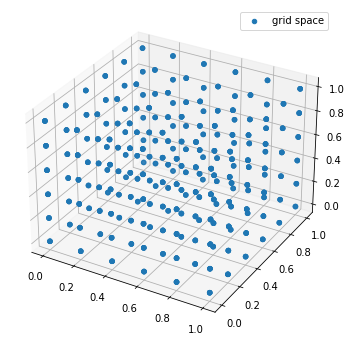

In [17]:
# Visualize an example grid space
grid_space = create_grid_space(granularity=6, dimensions=X.shape[1])
plot_grid_space(grid_space)

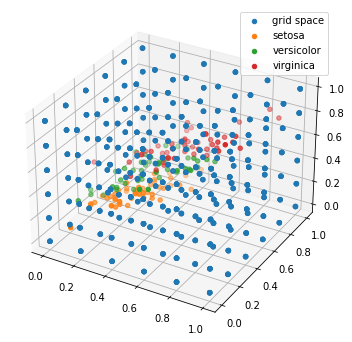

In [18]:
# Visualize grid space and original data
plot_gridAndData(grid_space, with_data=True, X=X, Y=Y, labels=labels)

In [19]:
# Run mountain clustering with train data
C_m, Y_hat_m, M_m = mountain_clustering(X, granularity=2, sigma=0.2, dist_type=2, verbose=True)

Calculating cluster center 0...
Cluster center 0 : [0. 1. 0. 0.]
Mountain center value 3.8438099103680727
Calculating cluster center 1...
Cluster center 1 : [1. 0. 1. 1.]
Mountain center value 1.034676050394805
Calculating cluster center 2...
Cluster center 2 : [1. 1. 1. 1.]
Mountain center value 0.8288423341872719
Calculating cluster center 3...
Number of clusters found: 3 
 with points [[0. 1. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]]


In [20]:
# Gather results in a data frame
results_m = results2df(pd.DataFrame(X, columns=names), names, Y_hat_m, C_m)

In [21]:
# Visualize results in 2D
plotly_scatter(results_m, names, plot_type="2D", color=results_m.columns[-1],
               title="Centers obtained from density-based clustering for train data", opacity=0.7)

In [22]:
# Visualize results in 3D
plotly_scatter(results_m, names, plot_type="3D", color=results_m.columns[-1],
               title="Centers obtained from density-based clustering for train data", opacity=0.7)

## Substractive

In [23]:
def substractive_clustering(X, ra=0.2, rb=None, dist_type=2, tol = 1e-3, verbose=True):
    """A clustering algorithm that uses a mountain matrix to cluster data.

    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        K (_int_): the number of clusters.
        ra (_float_): the height and the smoothing of the mountain function. Is an application specific parameter, that
        acts as the kernel influence or bandwidth for the mountain function construction and update.
        rb (_float_, optional): the height and the smoothing of the updated mountain function. Defaults to None, as it
        is internally defined as 2*ra.
        dist_type (_int_, optional): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine. Defaults to 2.
        tol (_float_, optional): the tolerance for the stopping criterion. Defaults to 1e-3.

    Returns:
        _tuple_: a tuple containing the cluster centers, the resulting cluster labels and the mountain matrix.
    """
    if rb is None:
        rb = 2*ra

    num_obs, num_features = X.shape
    
    # Assume a big fixed number of clusters
    K = 100

    # Initialize mountain matrix and mountain centers
    density= np.zeros(num_obs)
    density_centers = np.zeros(K)
    # Initialize cluster centers
    C = np.zeros(shape=(K, num_features))
    C_idx = np.zeros(K).astype(int)

    # Calculate the mountain matrix for the remaining cluster centers (except the first one)
    cluster = 0
    while True:
        if verbose:
            print(f'Calculating cluster center {cluster}...')
        for i in range(num_obs):
            for j in range(num_obs):
                if cluster == 0:
                    density[i] += np.exp(-distance(X[i,:], X[j,:], dist_type) / (ra/2)**2)
                else:
                    density[i] -= density_centers[cluster-1]*np.exp(-distance(X[i,:], C[cluster-1], dist_type) / (rb/2)**2)
        
        # Get index of maximum value in mountain matrix
        C_idx[cluster] = int(np.argmax(density))
        # Set current cluster as the maximum value in mountain matrix
        new_center = X[C_idx[cluster], :]
        new_density = density[C_idx[cluster]]
        # Stop criteria Check if the new center is already in the list of centers or if the mountain value is too small.
        if ( np.any(np.equal(C, new_center).all(axis=1)) ) or (
            abs(new_density) < tol) or (abs(new_density / density_centers[cluster-1]) < 1e-1
        ):
            C = C[:cluster, :]
            C_idx = C_idx[:cluster]
            density_centers = density_centers[:cluster]
            if verbose:
                print(f'Number of clusters found: {cluster} \n with points {C}')
            break
        
        # Update the cluster centers and mountain centers
        C[cluster, :] = new_center
        density_centers[cluster] = density[C_idx[cluster]]
        
        # Print the current cluster center and mountain center value
        if verbose:
            print(f'Cluster center {cluster} : {C[cluster]}')
            print(f'Mountain center value {density_centers[cluster]}')
        
        # Advance to the next cluster
        cluster += 1

    # Calculate which points are within each cluster
    Y_hat = np.zeros(num_obs)
    Y_hat = np.argmin(np.linalg.norm(X[:, np.newaxis, :] - C[np.newaxis, :, :], axis=2), axis=1)
    return C, Y_hat, density

### Example on iris data set

In [24]:
# Run substractive clustering
C_s, Y_hat_s, density_s = substractive_clustering(X, ra=0.4, dist_type = 2, tol = 1e-3, verbose=False)

In [25]:
# Gather results in a data frame
results_s = results2df(pd.DataFrame(X, columns=names), names, Y_hat_s, C_s)

In [26]:
# Visualize results in 2D
plotly_scatter(results_s, names, plot_type="2D", color=results_s.columns[-1],
               title="Centers obtained from density-based clustering for train data", opacity=0.7)

In [27]:
# Visualize results in 3D
plotly_scatter(results_s, names, plot_type="3D", color=results_s.columns[-1],
               title="Centers obtained from density-based clustering for train data", opacity=0.7)

## $k$-means

In [28]:
def kmeans(x, k, max_iter=100, tol=1e-3, dist_type=2, verbose=False, init=None):
    """ K-means algorithm.
    
    Args:
        x (np.array): the features of data to be clustered, usually structured as tidy data.
        k (int): the number of clusters.
        max_iter (int): the maximum number of iterations.
        tol (float): the tolerance for the stopping criterion.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
        verbose (bool): whether to print the cost function at each iteration.
        init (list): the initial centers.
        
    Returns:
        np.array: the cluster centers.
        np.array: the resulting cluster labels.
        np.array: the membership matrix.
        np.array: the cost function at each iteration.
    """
    
    if init is None:
        init = []
    n_obs = x.shape[0]
    # Initialization of the centers.
    if init == [] or len(init) != k:
        init = np.random.choice(n_obs, k, replace=False)
    centers = x[init, :]
    costs = np.zeros(max_iter+1)
    iteration = 0
    while True:
        # Determine of membership of each observation to each cluster.
        membership = np.zeros((n_obs, n_obs), dtype=np.int32)
        for j in range(n_obs):
            min_dist = np.inf
            min_idx = 0
            for i, center in enumerate(centers):
                dist = distance(x[j,:], center, dist_type)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = i
            membership[j, min_idx] = 1

        # Compute the cost function.
        cost = 0
        for j in range(n_obs):
            for i in range(k):
                if membership[j, i] == 1:
                    cost = cost + distance(x[j,:], centers[i,:], dist_type)

        costs[iteration-1] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1 and (
            abs(cost - costs[iteration - 2]) < tol or iteration > max_iter
        ):
            break
        # Update the centers.
        for i in range(k):
            centers[i, :] = np.mean(x[membership[:, i] == 1, :], axis=0)

        iteration = iteration + 1

        if verbose:
            print(f'Iteration: {iteration}, Cost: {cost}')

    return centers, membership, costs

### Example on iris data set

In [29]:
# Run k-means
C_k, membership_k, costs_k = kmeans(X, k=3, max_iter=100, tol=1e-3, dist_type=2, verbose=True, init=None)

Iteration: 1, Cost: 36.971706042083525
Iteration: 2, Cost: 29.85725814421475
Iteration: 3, Cost: 29.476313680239894
Iteration: 4, Cost: 29.414803172425454
Iteration: 5, Cost: 29.428888983922267
Iteration: 6, Cost: 29.413932034625773
Iteration: 7, Cost: 29.3863157191181
Iteration: 8, Cost: 29.38929584991975
Iteration: 9, Cost: 29.436129527525676


In [30]:
# Transform membership matrix into cluster labels
Y_hat_k = membership_to_labels(membership_k)

In [31]:
# Gather results in a data frame
results_k = results2df(pd.DataFrame(X, columns=names), names, Y_hat_k, C_k)

In [32]:
# Visualize results in 2D
plotly_scatter(results_k, names, plot_type="2D", color=results_k.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

In [33]:
# Visualize results in 3D
plotly_scatter(results_k, names, plot_type="3D", color=results_k.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

## fuzzy $c$-means

In [34]:
def fuzzyCmeans(x, k, m=2, max_iter=100, tol=1e-3, dist_type=2, verbose=False):
    """ Fuzzy C-means algorithm.
    
    Args:
        x (np.array): the features of data to be clustered, usually structured as tidy data.
        k (int): the number of clusters.
        m (float): the fuzziness parameter.
        max_iter (int): the maximum number of iterations.
        tol (float): the tolerance for the stopping criterion.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
        verbose (bool): whether to print the cost function at each iteration.
        
    Returns:
        np.array: the cluster centers.
        np.array: the membership matrix.
        np.array: the cost function at each iteration.
    """
       
    n_obs, n_features = x.shape
    # Initialization the membership matrix.
    membership = np.random.rand(n_obs, k)
    membership = membership / np.sum(membership, axis=1, keepdims=True)

    iteration = 0
    centers = np.zeros((k, n_features))
    costs = np.zeros(max_iter+1)
    while True:
        # Calculate the centers.
        for i in range(k):
            centers[i, :] = membership[:, i] * m @ x / np.sum(membership[:, i] * m)

        # Compute the cost function.
        cost = 0
        for i in range(k):
            for j in range(n_obs):
                cost = cost + membership[j, i] ** m * distance(centers[i,:], x[j,:], dist_type)
        costs[iteration] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1 and (
            abs(cost - costs[iteration - 2]) < tol or iteration > max_iter
        ):
            break
        # Update the membership matrix.
        for i in range(k):
            for j in range(n_obs):
                den = 0
                for l in range(k):
                    den = den + (distance(x[j,:], centers[i,:], dist_type) / distance(x[j,:], centers[l,:], dist_type)) ** (2/(m-1))
                membership[j, i] = 1 / den

        iteration = iteration + 1

        if verbose:
            print(f'Iteration: {iteration}, Cost: {cost}')

    return centers, membership, costs

### Example on iris data set

In [35]:
# Run fuzzy c-means
C_c, membership_c, costs_c = fuzzyCmeans(X, k=3, m=2, max_iter=100, tol=1e-3, dist_type=2, verbose=True)

Iteration: 1, Cost: 31.797429663984268
Iteration: 2, Cost: 24.170206880543887
Iteration: 3, Cost: 24.075882173563038
Iteration: 4, Cost: 23.905766712311955
Iteration: 5, Cost: 23.57371089810164
Iteration: 6, Cost: 22.9734185806392
Iteration: 7, Cost: 22.082409089529705
Iteration: 8, Cost: 21.233626181800492
Iteration: 9, Cost: 20.870243934696774
Iteration: 10, Cost: 20.84512849283042
Iteration: 11, Cost: 20.874429808729964
Iteration: 12, Cost: 20.89656880368038
Iteration: 13, Cost: 20.90938655822836
Iteration: 14, Cost: 20.917516408466945
Iteration: 15, Cost: 20.923418916514255
Iteration: 16, Cost: 20.9280253676733
Iteration: 17, Cost: 20.931706948989074
Iteration: 18, Cost: 20.93465897295096
Iteration: 19, Cost: 20.937018232474937
Iteration: 20, Cost: 20.938894983742287
Iteration: 21, Cost: 20.940381381069678
Iteration: 22, Cost: 20.941554286270325
Iteration: 23, Cost: 20.94247707138343
Iteration: 24, Cost: 20.94320136780353
Iteration: 25, Cost: 20.943768820178647
Iteration: 26, Cost:

In [36]:
# Transform membership matrix into cluster labels
Y_hat_c = membership_to_labels(membership_c)

In [37]:
# Gather results in a data frame
results_c = results2df(pd.DataFrame(X, columns=names), names, Y_hat_c, C_c)

In [38]:
# Visualize results in 2D
plotly_scatter(results_c, names, plot_type="2D", color=results_c.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

In [39]:
# Visualize results in 3D
plotly_scatter(results_c, names, plot_type="3D", color=results_c.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

## $k$-medoids

In [40]:
# k-medoids clustering algorithm. Output centers, membership and cost function.
def kmedoids(x, k, max_iter=100, tol=1e-3, dist_type=2, verbose=False, init=None):
    """ K-medoids algorithm.
    
    Args:
        x (np.array): the features of data to be clustered, usually structured as tidy data.
        k (int): the number of clusters.
        max_iter (int): the maximum number of iterations.
        tol (float): the tolerance for the stopping criterion.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
        verbose (bool): whether to print the cost function at each iteration.
        init (list): the initial centers.
        
    Returns:
        np.array: the cluster centers.
        np.array: the resulting cluster labels.
        np.array: the membership matrix.
        np.array: the cost function at each iteration.
    """
    
    if init is None:
        init = []
    n_obs = x.shape[0]
    # Initialization of the centers.
    if init == [] or len(init) != k:
        init = np.random.choice(n_obs, k, replace=False)
    centers = x[init, :]
    costs = np.zeros(max_iter+1)
    iteration = 0
    while True:
        # Determine of membership of each observation to each cluster.
        membership = np.zeros((n_obs, n_obs), dtype=np.int32)
        for j in range(n_obs):
            min_dist = np.inf
            min_idx = 0
            for i, center in enumerate(centers):
                dist = distance(x[j,:], center, dist_type)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = i
            membership[j, min_idx] = 1

        # Compute the cost function.
        cost = 0
        for j in range(n_obs):
            for i in range(k):
                if membership[j, i] == 1:
                    cost = cost + distance(x[j,:], centers[i,:], dist_type)

        costs[iteration-1] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1 and (
            abs(cost - costs[iteration - 2]) < tol or iteration > max_iter
        ):
            break
        # Update the centers
        for i in range(k):
            min_cost = np.inf
            for j in range(n_obs):
                if membership[j, i] == 1:
                    cost = 0
                    for l in range(n_obs):
                        if membership[l, i] == 1:
                            cost = cost + distance(x[j,:], x[l,:], dist_type)
                    if cost < min_cost:
                        min_cost = cost
                        centers[i,:] = x[j,:]
        iteration = iteration + 1
        if verbose:
            print(f'Iteration: {iteration}, Cost: {cost}')

    return centers, membership, costs

### Example on iris data set

In [41]:
# Run k-medoids
C_km, membership_km, costs_km = kmedoids(X, k=3, max_iter=100, tol=1e-3, dist_type=2, verbose=True, init=None)

Iteration: 1, Cost: 2.4167943010738084
Iteration: 2, Cost: 10.592966844210045
Iteration: 3, Cost: 9.942936699580862
Iteration: 4, Cost: 9.355937278648025


In [42]:
# Transform membership matrix into cluster labels
Y_hat_km = membership_to_labels(membership_km)

In [43]:
# Gather results in a data frame
results_km = results2df(pd.DataFrame(X, columns=names), names, Y_hat_km, C_km)

In [44]:
# Visualize results in 2D
plotly_scatter(results_km, names, plot_type="2D", color=results_km.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

In [45]:
# Visualize results in 3D
plotly_scatter(results_km, names, plot_type="3D", color=results_km.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

# Clustering validation indexes

Clustering validation indexes are used to evaluate the quality and performance of clustering algorithms. They measure how well the clustering algorithm has grouped similar objects together and separated dissimilar objects. There are two types:


1. **Internal validation indexes:** they are used to evaluate the quality and performance of clustering algorithms based on the data alone, without considering any external information or ground truth. For example: `davies_bouldin_index`, `dunn_index` and `calinski_harabasz_index`.


2. **External validation indexes:** they are used to evaluate the quality and performance of clustering algorithms by comparing the clustering results to external information or ground truth, such as class labels or a labeled dataset. For example: `rand_index`, `jaccard_index` and `fowlkes_mallows_index`.



## Internal validation indexes

In [46]:
# Internal validation indices ----------------------------------------------------

# Davies-Bouldin index
def davies_bouldin_index(X, Y, C):
    """ Davies-Bouldin index. This index is a measure of how well a clustering algorithm
    separates the clusters. The lower the index, the better the clustering. The idea behind this index
    is to measure the distance between clusters and the distance between points within each cluster. It does so
    by calculating the average distance between each cluster and its points and the distance between each pair of clusters.
    This index is a measure of cohesion and separation, which means that it is a measure of how well the clusters are
    separated and how well the points are clustered within each cluster.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Davies-Bouldin index.
    """
    n_obs, n_features = X.shape
    k = len(np.unique(Y))
    # Calculate the distance between each pair of clusters.
    dist = np.zeros((k, k))
    for i, j in itertools.product(range(k), range(k)):
        if i != j:
            dist[i, j] = distance(C[i,:], C[j,:], 2)
    # Calculate the average distance between each cluster and its points.
    avg_dist = np.zeros(k)
    for i in range(k):
        avg_dist[i] = np.mean(distance(X[Y == i, :], C[i,:], 2))
    # Calculate the Davies-Bouldin index.
    DB = 0
    for i in range(k):
        max_dist = 0
        for j in range(k):
            if i != j:
                max_dist = max(max_dist, (avg_dist[i] + avg_dist[j]) / dist[i, j])
        DB = DB + max_dist
    DB = DB / k
    return DB

# Dunn index
def dunn_index(X, Y, C):
    """ Dunn index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the distance
    between clusters and the distance between points within each cluster. It does so by calculating the minimum
    distance between each cluster and its points and the maximum distance between each pair of clusters.
    This index is a measure of cohesion and separation, which means that it is a measure of how well the clusters are
    separated and how well the points are clustered within each cluster.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Dunn index.
    """
    n_obs, n_features = X.shape
    k = len(np.unique(Y))
    # Calculate the distance between each pair of clusters.
    dist = np.zeros((k, k))
    for i, j in itertools.product(range(k), range(k)):
        if i != j:
            dist[i, j] = distance(C[i,:], C[j,:], 2)
    # Calculate the minimum distance between each cluster and its points.
    min_dist = np.zeros(k)
    for i in range(k):
        min_dist[i] = np.min(distance(X[Y == i, :], C[i,:], 2))
    # Calculate the Dunn index.
    return np.min(min_dist) / np.max(dist)

# Calinski-Harabasz index
def calinski_harabasz_index(X, Y, C):
    """ Calinski-Harabasz index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the distance between
    clusters and the distance between points within each cluster. It does so by calculating the average distance between
    each cluster and its points and the distance between each pair of clusters. This index is a measure of cohesion and
    separation, which means that it is a measure of how well the clusters are separated and how well the points are
    clustered within each cluster.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Calinski-Harabasz index.
    """
    n_obs, n_features = X.shape
    k = len(np.unique(Y))
    # Calculate the distance between each pair of clusters.
    dist = np.zeros((k, k))
    for i, j in itertools.product(range(k), range(k)):
        if i != j:
            dist[i, j] = distance(C[i,:], C[j,:], 2)
    # Calculate the average distance between each cluster and its points.
    avg_dist = np.zeros(k)
    for i in range(k):
        avg_dist[i] = np.mean(distance(X[Y == i, :], C[i,:], 2))
    # Calculate the total average distance between all points and the global center.
    avg_dist_all = np.mean(distance(X, np.mean(X, axis=0), 2))
    # Calculate the Calinski-Harabasz index.
    return (np.sum((k * avg_dist - avg_dist_all) ** 2)) / (k * np.sum(dist))

# Create a function to calculate the internal validation indices
def internal_validation_indices(X, Y, C):
    """ Calculate the internal validation indices. This function computes the Davies-Bouldin index,
    the Dunn index, and the Calinski-Harabasz index. Davies-Bouldin: lower is better, Dunn: higher is better,
    Calinski-Harabasz: higher is better.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Davies-Bouldin index.
        float: the Dunn index.
        float: the Calinski-Harabasz index.
    """
    DB = davies_bouldin_index(X, Y, C)
    DI = dunn_index(X, Y, C)
    CH = calinski_harabasz_index(X, Y, C)
    print(f"Davies-Bouldin index: {DB:.3f}, Dunn index: {DI:.3f}, Calinski-Harabasz index: {CH:.3f}")
    return DB, DI, CH

## External validation indexes

In [47]:
# External validation indices ---------------------------------------------------

# Rand index
def rand_index(Y, Y_hat):
    """ Rand index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the number of
    pairs of points that are correctly and incorrectly clustered. This index is a measure of the similarity
    between the true labels and the predicted labels.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Rand index.
    """
    n_obs = len(Y)
    a = 0
    b = 0
    c = 0
    d = 0
    for i, j in itertools.product(range(n_obs), range(n_obs)):
        if Y[i] == Y[j] and Y_hat[i] == Y_hat[j]:
            a = a + 1
        elif Y[i] != Y[j] and Y_hat[i] != Y_hat[j]:
            b = b + 1
        elif Y[i] == Y[j]:
            c = c + 1
        else:
            d = d + 1
    return (a + b) / (a + b + c + d)

# Jaccard index
def jaccard_index(Y, Y_hat):
    """ Jaccard index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the number of
    pairs of points that are correctly and incorrectly clustered. This index is a measure of the similarity
    between the true labels and the predicted labels.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Jaccard index.
    """
    n_obs = len(Y)
    a = 0
    b = 0
    c = 0
    for i, j in itertools.product(range(n_obs), range(n_obs)):
        if Y[i] == Y[j] and Y_hat[i] == Y_hat[j]:
            a = a + 1
        elif Y[i] != Y[j] and Y_hat[i] != Y_hat[j]:
            b = b + 1
        else:
            c = c + 1
    return a / (a + b + c)

# Fowlkes-Mallows index
def fowlkes_mallows_index(Y, Y_hat):
    """ Fowlkes-Mallows index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the number of
    pairs of points that are correctly and incorrectly clustered. This index is a measure of the similarity
    between the true labels and the predicted labels.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Fowlkes-Mallows index.
    """
    n_obs = len(Y)
    a = 0
    b = 0
    c = 0
    d = 0
    for i, j in itertools.product(range(n_obs), range(n_obs)):
        if Y[i] == Y[j] and Y_hat[i] == Y_hat[j]:
            a = a + 1
        elif Y[i] != Y[j] and Y_hat[i] != Y_hat[j]:
            b = b + 1
        elif Y[i] == Y[j]:
            c = c + 1
        else:
            d = d + 1
    return np.sqrt(a / (a + c)) * np.sqrt(a / (a + d))

# Create a function to calculate the external validation indices
def external_validation_indices(Y, Y_hat):
    """ Calculate the external validation indices. This function computes the Rand index, the Jaccard index,
    and the Fowlkes-Mallows index. Rand: higher is better, Jaccard: higher is better, Fowlkes-Mallows: higher is better.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Rand index.
        float: the Jaccard index.
        float: the Fowlkes-Mallows index.
    """
    RI = rand_index(Y, Y_hat)
    JI = jaccard_index(Y, Y_hat)
    FMI = fowlkes_mallows_index(Y, Y_hat)
    print(f"Rand index: {RI:.3f}, Jaccard index: {JI:.3f}, Fowlkes-Mallows index: {FMI:.3f}")
    return RI, JI, FMI

## Example on iris data set

### Indexes for mountain

In [48]:
# Run internal and external validation indices using the results from mountain
DB_m, DI_m, CH_m = internal_validation_indices(X, Y, C_m)
RI_m, JI_m, FMI_m = external_validation_indices(Y, Y_hat_m)

Davies-Bouldin index: 10.011, Dunn index: 1.764, Calinski-Harabasz index: 11.111
Rand index: 0.740, Jaccard index: 0.261, Fowlkes-Mallows index: 0.675


### Indexes for substractive

In [49]:
# Run internal and external validation indices using the results from substractive
DB_s, DI_s, CH_s = internal_validation_indices(X, Y, C_s)
RI_s, JI_s, FMI_s = external_validation_indices(Y, Y_hat_s)

Davies-Bouldin index: 10.365, Dunn index: 1.112, Calinski-Harabasz index: 5.484
Rand index: 0.853, Jaccard index: 0.261, Fowlkes-Mallows index: 0.780


### Indexes for $k$-means

In [50]:
# Run internal and external validation indices using the results from k-means
DB_k, DI_k, CH_k = internal_validation_indices(X, Y, C_k)
RI_k, JI_k, FMI_k = external_validation_indices(Y, Y_hat_k)

Davies-Bouldin index: 16.017, Dunn index: 1.722, Calinski-Harabasz index: 15.337
Rand index: 0.869, Jaccard index: 0.268, Fowlkes-Mallows index: 0.803


### Indexes for fuzzy $c$-means

In [51]:
# Run internal and external validation indices using the results from fuzzy c-means
DB_c, DI_c, CH_c = internal_validation_indices(X, Y, C_c)
RI_c, JI_c, FMI_c = external_validation_indices(Y, Y_hat_c)

Davies-Bouldin index: 33.537, Dunn index: 2.855, Calinski-Harabasz index: 35.564
Rand index: 0.913, Jaccard index: 0.290, Fowlkes-Mallows index: 0.870


### Indexes for $k$-medoids

In [52]:
# Run internal and external validation indices using the results from k-medoids
DB_km, DI_km, CH_km = internal_validation_indices(X, Y, C_km)
RI_km, JI_km, FMI_km = external_validation_indices(Y, Y_hat_km)

Davies-Bouldin index: 52.550, Dunn index: 5.823, Calinski-Harabasz index: 50.931
Rand index: 0.724, Jaccard index: 0.271, Fowlkes-Mallows index: 0.674


# Experiment on real data

To experiment on real data we will use unlabeled data. This means that the use of density-based clustering will serve as an exploratory approach to decide the optimal number of clusters $k$. Afterwards, we will use distance-based clustering to cluster the data given the amount of optimal clusters $k$. 

We will run every density-based and distance-based clustering methods on 3 rounds with: the original data, the UMAP embedded data in a low-dimensional space, and the hig-dimensional data space resulting from the autoencoder.

## Auxiliary functions

In [53]:
# Function to clean raw data
def clean_data(df, features2drop):
    """ Clean the data. This function removes categorical features, removes NA values, and normalizes the data.
    
    Args:
        df (pd.DataFrame): the data to be cleaned.
        features2drop (list): the list of categorical features to be removed.
        seed (int): the random seed.
        
    Returns:
        pd.DataFrame: the cleaned data.
        list: the list of feature names.
    """

    new_df = df.copy()
    # Remove categorical features
    new_df.drop(features2drop, axis=1, inplace=True)

    # Remove NA values if there are any
    if new_df.isnull().values.sum() > 0:
        new_df.dropna(axis=0, inplace=True)

    # Normalize the data to the hypercube [0,1]
    new_df = normalize_data(new_df)

    # Extract feature names
    names = new_df.columns

    return new_df, names

# Define a function that takes a clustering algorithm, the data, and the parameter values to run on multiple configurations
# for each configuration, run the algorithm and compute only the internal index. Allow for multiple grids of parameters
def run_clustering_algorithm(algorithm, data, param_grid, params):
    """ Run a clustering algorithm on multiple configurations.
    
    Args:
        algorithm (function): the clustering algorithm to be run.
        data (np.array): the data to be clustered.
        param_grid (list): the list of parameter values to be used.
        params (dict): the parameters of the algorithm.
        
    Returns:
        pd.DataFrame: the results of the clustering algorithm.
    """
    # Create an empty data frame to store the results
    results_df = pd.DataFrame(columns=["algorithm", "configuration", "Davies-Bouldin", "Dunn", "Calinski-Harabasz", "number of clusters"])

    # Loop over the parameter grid
    for i, configuration in enumerate(param_grid):
        # Update the parameters
        params.update(configuration)

        # Run the algorithm
        C, Y_hat, _ = algorithm(data, **params)
        
        # Get algorithm name
        algorithm_name = algorithm.__name__
        
        if algorithm_name in ["kmeans", "fuzzyCmeans", "kmedoids"]:
            # Convert membership matrix to labels
            Y_hat = membership_to_labels(Y_hat)

        # Compute internal validation indices
        DB, DI, CH = internal_validation_indices(data, Y_hat, C)

        # Store the results in a data frame
        results_df.loc[i] = [algorithm_name, configuration, DB, DI, CH, len(C)]
        
    # Resort the results so the row with the highest DI, lowest DB, and highest CH is first
    best_configuration = results_df.sort_values(by=["Dunn", "Davies-Bouldin", "Calinski-Harabasz"], ascending=[False, True, False]).iloc[0]

    return results_df, best_configuration

# define a function to experiment with the clustering algorithms on multiple configurations
def experiment(algorithm, data, param_grids, params):
    """ Run a clustering algorithm on multiple configurations and multiple parameter grids.
    
    Args:
        algorithm (function): the clustering algorithm to be run.
        data (np.array): the data to be clustered.
        param_grids (list): the list of parameter grids to be used.
        params (dict): the parameters of the algorithm.
        
    Returns:
        pd.DataFrame: the results of the clustering algorithm.
    """
    # Create an empty data frame to store the results
    column_names = ["algorithm", "configuration", "Davies-Bouldin", "Dunn", "Calinski-Harabasz", "number of clusters"]
    results_df = pd.DataFrame(columns=column_names)

    # Loop over the parameter grids
    for param_grid in param_grids:
        # Run the algorithm
        results, best_configuration = run_clustering_algorithm(algorithm, data, param_grid, params)
        # Concatenate the results
        results_df = pd.concat([results_df, results], axis=0, ignore_index=True)

    # Resort the results so the row with the highest DI, lowest DB, and highest CH is first
    best_configuration = results_df.sort_values(by=["Dunn", "Davies-Bouldin", "Calinski-Harabasz"], ascending=[False, True, False]).iloc[0]

    return results_df, best_configuration

# Define a function to choose the best configuration overall given a list of best configurations
def best_configuration_overall(best_configurations):
    """ Choose the best configuration overall given a list of best configurations.
    
    Args:
        best_configurations (list): the list of best configurations.
        
    Returns:
        pd.DataFrame: the best configuration overall.
    """
    # Create an empty data frame to store the results
    column_names = ["algorithm", "configuration", "Davies-Bouldin", "Dunn", "Calinski-Harabasz", "number of clusters", "distance"]
    results_df = pd.DataFrame(columns=column_names)
    
    # Convert each item of the list to a data frame
    best_configurations = [pd.DataFrame([item], columns=column_names) for item in best_configurations]

    # Loop over the best configurations
    for best_configuration in best_configurations:
        # Concatenate the results
        results_df = pd.concat([results_df, best_configuration], axis=0, ignore_index=True)

    # Resort the results so the row with the lowest DB, highest DI and highest CH is first
    best_configuration = results_df.sort_values(by=["Dunn", "Davies-Bouldin", "Calinski-Harabasz"], ascending=[False, True, False]).iloc[0]

    return best_configuration

## Load the data
We use the Mall Customer Segmentation Data ([link to source](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)) which was created for the learning purpose of the customer segmentation concepts, also known as market basket analysis. It contains some basic data about customers like Customer ID, age, gender, annual income and spending score.
Spending Score is a measure assigned to the customer based on predefined parameters like customer behavior and purchasing data.

The data contains 200 customers (rows or observations) with 4 customer features. Because the first feature is categorical (Gender) we remove it. This leaves us with 3 features and, therefore, a 3D space.

In [54]:
# Load and read data set
url = "https://github.com/scardenol/ai_2023/blob/e109f1cc834fa52bcccf49cda29463c9160d164d/3.%20Unsupervised/entrega_Salo/data/Mall_Customers.xls?raw=true"
raw_data = pd.read_csv(url, index_col=0)

In [55]:
# View shape of data
raw_data.shape

(200, 4)

In [56]:
# Visualize data set
raw_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## Preprocess

In [57]:
# Remove categorical features, remove NA values, and normalize the data
data, names = clean_data(raw_data, features2drop=['Gender'])

# Set random seed
seed = 0
np.random.seed(seed)

## Visualize

In [58]:
plotly_scatter(data, names, plot_type="3D", title="Original data", opacity=0.7)

## Find the optimal number of clusters $k$

To choose the optimal number of clusters $k$ we explore by experimenting with the density-based clustering methods: mountain and substractive. The idea is to consider different hyperparameters configurations for each of our distances: Manhattan, Euclidean, Mahalanobis and Cosine. This approach is similar to an hyperparameter grid search in an heuristic context. We perform the search by having a default set of values for the parameters and running the algorithm with the variation of one parameter at a time.

For each distance we select a candidate number of clusters by sorting the results with the internal validation indexes, so the candidate is selected as the configuration that yielded the lowest Davies-Bouldin index, highest Dunn index and highest Calinski-Harabasz index. Afterwards, we join the results for each distance and select the best candidate for each method, and finally, the best of both methods by following the same selection criteria.

### Experiment with mountain

In [59]:
# Run for manhattan distance
dist_type = 1

# Define the parameter grids
param_grids = [[{"granularity": 3}, {"granularity": 4}, {"granularity": 5}],
               [{"sigma":0.2}, {"sigma":0.3}, {"sigma":0.4}]]
# Define the parameters
params = {"beta":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
results_m1, best_configuration_m1 = experiment(mountain_clustering, data.values, param_grids, params)

Davies-Bouldin index: 9.638, Dunn index: 0.283, Calinski-Harabasz index: 3.118
Davies-Bouldin index: 11.568, Dunn index: 0.193, Calinski-Harabasz index: 3.231
Davies-Bouldin index: 12.226, Dunn index: 0.142, Calinski-Harabasz index: 3.894
Davies-Bouldin index: 12.226, Dunn index: 0.142, Calinski-Harabasz index: 3.894
Davies-Bouldin index: 8.247, Dunn index: 0.000, Calinski-Harabasz index: 1.216
Davies-Bouldin index: 12.086, Dunn index: 0.000, Calinski-Harabasz index: 3.181


In [60]:
# Visualize results
# Results data frame
print("Results for Manhattan distance")
display(results_m1)
# Add the distance type to the best configuration
best_configuration_m1.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_m1

Results for Manhattan distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,mountain_clustering,{'granularity': 3},9.638143,0.283042,3.118204,7
1,mountain_clustering,{'granularity': 4},11.568284,0.192808,3.231311,12
2,mountain_clustering,{'granularity': 5},12.226288,0.142151,3.893757,14
3,mountain_clustering,{'sigma': 0.2},12.226288,0.142151,3.893757,14
4,mountain_clustering,{'sigma': 0.3},8.246611,0.000000,1.215639,22
5,mountain_clustering,{'sigma': 0.4},12.085689,0.000000,3.181116,19


Best configuration:


algorithm             mountain_clustering
configuration          {'granularity': 3}
Davies-Bouldin                   9.638143
Dunn                             0.283042
Calinski-Harabasz                3.118204
number of clusters                      7
distance                                1
Name: 0, dtype: object

In [61]:
# Run for euclidean distance
dist_type = 2

# Define the parameter grids
param_grids = [[{"granularity": 3}, {"granularity": 4}, {"granularity": 5}],
               [{"sigma":0.2}, {"sigma":0.3}, {"sigma":0.4}]]
# Define the parameters
params = {"beta":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
results_m2, best_configuration_m2 = experiment(mountain_clustering, data.values, param_grids, params)

Davies-Bouldin index: 11.121, Dunn index: 0.380, Calinski-Harabasz index: 5.972
Davies-Bouldin index: 8.608, Dunn index: 0.000, Calinski-Harabasz index: 1.873
Davies-Bouldin index: 8.150, Dunn index: 0.000, Calinski-Harabasz index: 1.354
Davies-Bouldin index: 8.150, Dunn index: 0.000, Calinski-Harabasz index: 1.354
Davies-Bouldin index: 11.137, Dunn index: 0.000, Calinski-Harabasz index: 3.282
Davies-Bouldin index: 13.815, Dunn index: 0.000, Calinski-Harabasz index: 4.424


In [62]:
# Visualize results
# Results data frame
print("Results for Euclidean distance")
display(results_m2)
# Add the distance type to the best configuration
best_configuration_m2.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_m2

Results for Euclidean distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,mountain_clustering,{'granularity': 3},11.120957,0.379741,5.972434,8
1,mountain_clustering,{'granularity': 4},8.607766,0.000000,1.873332,16
2,mountain_clustering,{'granularity': 5},8.149712,0.000000,1.353948,23
3,mountain_clustering,{'sigma': 0.2},8.149712,0.000000,1.353948,23
4,mountain_clustering,{'sigma': 0.3},11.137404,0.000000,3.282173,19
5,mountain_clustering,{'sigma': 0.4},13.814783,0.000000,4.423905,15


Best configuration:


algorithm             mountain_clustering
configuration          {'granularity': 3}
Davies-Bouldin                  11.120957
Dunn                             0.379741
Calinski-Harabasz                5.972434
number of clusters                      8
distance                                2
Name: 0, dtype: object

In [63]:
# Run for mahalanobis distance
dist_type = "mahal"

# Define the parameter grids
param_grids = [[{"granularity": 3}, {"granularity": 4}, {"granularity": 5}],
               [{"sigma":0.2}, {"sigma":0.3}, {"sigma":0.4}]]
# Define the parameters
params = {"beta":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
#results_m3, best_configuration_m3 = experiment(mountain_clustering, data.values, param_grids, params)

One iteration of the method didn't work with Mahalanobis. There is no candidate for this round.

In [64]:
# Run for cosine distance
dist_type = "cos"

# Define the parameter grids
param_grids = [[{"granularity": 3}, {"granularity": 4}, {"granularity": 5}],
               [{"sigma":0.2}, {"sigma":0.3}, {"sigma":0.4}]]
# Define the parameters
params = {"beta":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
#results_m4, best_configuration_m4 = experiment(mountain_clustering, data.values, param_grids, params)

One iteration of the method didn't work with Cosine. There is no candidate for this round.

In [65]:
# Choose the best configuration overall
candidates_m = [best_configuration_m1, best_configuration_m2]
best_configuration_m = best_configuration_overall(candidates_m)

In [66]:
# Visualize results
best_configuration_m

algorithm             mountain_clustering
configuration          {'granularity': 3}
Davies-Bouldin                  11.120957
Dunn                             0.379741
Calinski-Harabasz                5.972434
number of clusters                      8
distance                                2
Name: 1, dtype: object

### Experiment with substractive

In [67]:
# Run for manhattan distance
dist_type = 1

# Define the parameter grids
param_grids = [[{"ra":0.2}, {"ra":0.3}, {"ra":0.4}]]
# Define the parameters
params = {"rb":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
results_s1, best_configuration_s1 = experiment(substractive_clustering, data.values, param_grids, params)

Davies-Bouldin index: 1.817, Dunn index: 0.000, Calinski-Harabasz index: 0.016
Davies-Bouldin index: 4.247, Dunn index: 0.203, Calinski-Harabasz index: 0.265
Davies-Bouldin index: 6.615, Dunn index: 0.602, Calinski-Harabasz index: 1.406


In [68]:
# Visualize results
# Results data frame
print("Results for Manhattan distance")
display(results_s1)
# Add the distance type to the best configuration
best_configuration_s1.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_s1

Results for Manhattan distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,substractive_clustering,{'ra': 0.2},1.816584,0.000000,0.015938,52
1,substractive_clustering,{'ra': 0.3},4.246953,0.202817,0.264774,12
2,substractive_clustering,{'ra': 0.4},6.614567,0.602140,1.406360,6


Best configuration:


algorithm             substractive_clustering
configuration                     {'ra': 0.4}
Davies-Bouldin                       6.614567
Dunn                                  0.60214
Calinski-Harabasz                     1.40636
number of clusters                          6
distance                                    1
Name: 2, dtype: object

In [69]:
# Run for euclidean distance
dist_type = 2

# Define the parameter grids
param_grids = [[{"ra":0.2}, {"ra":0.3}, {"ra":0.4}]]
# Define the parameters
params = {"rb":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
results_s2, best_configuration_s2 = experiment(substractive_clustering, data.values, param_grids, params)

Davies-Bouldin index: 2.489, Dunn index: 0.000, Calinski-Harabasz index: 0.058
Davies-Bouldin index: 6.248, Dunn index: 0.565, Calinski-Harabasz index: 1.337
Davies-Bouldin index: 9.377, Dunn index: 2.541, Calinski-Harabasz index: 9.909


In [70]:
# Visualize results
# Results data frame
print("Results for Euclidean distance")
display(results_s2)
# Add the distance type to the best configuration
best_configuration_s2.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_s2

Results for Euclidean distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,substractive_clustering,{'ra': 0.2},2.489401,0.000000,0.057994,29
1,substractive_clustering,{'ra': 0.3},6.247634,0.565072,1.337442,7
2,substractive_clustering,{'ra': 0.4},9.377141,2.540850,9.909114,2


Best configuration:


algorithm             substractive_clustering
configuration                     {'ra': 0.4}
Davies-Bouldin                       9.377141
Dunn                                  2.54085
Calinski-Harabasz                    9.909114
number of clusters                          2
distance                                    2
Name: 2, dtype: object

In [71]:
# Run for mahalanobis distance
dist_type = "mahal"

# Define the parameter grids
param_grids = [[{"ra":0.2}, {"ra":0.3}, {"ra":0.4}]]
# Define the parameters
params = {"rb":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
#results_s3, best_configuration_s3 = experiment(substractive_clustering, data.values, param_grids, params)

One iteration of the method didn't work with Mahalanobis. There is no candidate for this round.

In [72]:
# Run for mahalanobis distance
dist_type = "cos"

# Define the parameter grids
param_grids = [[{"ra":0.2}, {"ra":0.3}, {"ra":0.4}]]
# Define the parameters
params = {"rb":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
results_s4, best_configuration_s4 = experiment(substractive_clustering, data.values, param_grids, params)

Davies-Bouldin index: 10.045, Dunn index: 1.375, Calinski-Harabasz index: 2.028
Davies-Bouldin index: 0.000, Dunn index: inf, Calinski-Harabasz index: inf
Davies-Bouldin index: 8.347, Dunn index: 3.245, Calinski-Harabasz index: 4.878


In [73]:
# Visualize results
# Results data frame
print("Results for Cosine distance")
display(results_s4)
# Add the distance type to the best configuration
best_configuration_s4.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_s4

Results for Cosine distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,substractive_clustering,{'ra': 0.2},10.045108,1.374755,2.028106,4
1,substractive_clustering,{'ra': 0.3},0.000000,inf,inf,1
2,substractive_clustering,{'ra': 0.4},8.347213,3.244757,4.878466,2


Best configuration:


algorithm             substractive_clustering
configuration                     {'ra': 0.3}
Davies-Bouldin                            0.0
Dunn                                      inf
Calinski-Harabasz                         inf
number of clusters                          1
distance                                  cos
Name: 1, dtype: object

The best configuration for the cosine distance is one with infinite Dunn and Calinski-Harabasz indexes, which does not make any sense. Therefore, we select the second best as the candidate.

In [74]:
best_configuration_s4 = results_s4.sort_values(by=["Dunn", "Davies-Bouldin", "Calinski-Harabasz"],
                       ascending = [False, True, False]).iloc[1]
# Add the distance type to the best configuration
best_configuration_s4.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_s4

Best configuration:


algorithm             substractive_clustering
configuration                     {'ra': 0.4}
Davies-Bouldin                       8.347213
Dunn                                 3.244757
Calinski-Harabasz                    4.878466
number of clusters                          2
distance                                  cos
Name: 2, dtype: object

In [75]:
# Choose the best configuration overall
candidates_s = [best_configuration_s1, best_configuration_s2, best_configuration_s4]
best_configuration_s = best_configuration_overall(candidates_s)

In [76]:
# Visualize results
best_configuration_s

algorithm             substractive_clustering
configuration                     {'ra': 0.4}
Davies-Bouldin                       8.347213
Dunn                                 3.244757
Calinski-Harabasz                    4.878466
number of clusters                          2
distance                                  cos
Name: 2, dtype: object

### Optimal number of clusters $k$

In [77]:
# Select the best candidate of both methods as the optimal number of clusters
candidates_per_method = [best_configuration_m, best_configuration_s]
best_overall = best_configuration_overall(candidates_per_method)

In [78]:
# Visualize results
best_overall

algorithm             substractive_clustering
configuration                     {'ra': 0.4}
Davies-Bouldin                       8.347213
Dunn                                 3.244757
Calinski-Harabasz                    4.878466
number of clusters                          2
distance                                  cos
Name: 1, dtype: object

In [79]:
# Store resulting number of clusters as the optimal number of clusters
k = best_overall[-2]

# Store the distance of best overall to pass to distance-based methods
dist_type = best_overall[-1]

## Cluster the data
After determining the optimal number of clusters $k$ we simply run the distance-based methods ($k$-means, fuzzy $c$-means and $k$-medoids) to compute the centers for the data. The distance we use for both methods is simply the resulting distance for the best candidate overall.

### $k$-means

In [80]:
# Run k-means
C_k, membership_k, costs_k = kmeans(data.values, k=k, max_iter=100, tol=1e-3, dist_type=dist_type, verbose=True, init=None)

Iteration: 1, Cost: 36.845584286751986
Iteration: 2, Cost: 16.60997828054623
Iteration: 3, Cost: 15.720985719972681
Iteration: 4, Cost: 12.901981288163503
Iteration: 5, Cost: 11.674320883444247
Iteration: 6, Cost: 11.368147079200435
Iteration: 7, Cost: 11.334718605228629
Iteration: 8, Cost: 11.32662633288244


In [81]:
# Transform membership matrix into cluster labels
Y_hat_k = membership_to_labels(membership_k)

# Gather results and convert to data frame
results_k = results2df(data, names=data.columns, Y_hat=Y_hat_k, C=C_k)

In [82]:
# Plot results
plotly_scatter(results_k, names, plot_type="3D", color="cluster",
               title="Resulting clusters with k-means", opacity=0.7)

### fuzzy $c$-means

In [83]:
# Run fuzzy c-means
C_c, membership_c, costs_c = fuzzyCmeans(data.values, k=k, m=2, max_iter=100, tol=1e-3, dist_type=dist_type, verbose=True)

Iteration: 1, Cost: 14.001656940884747
Iteration: 2, Cost: 11.348278868920326
Iteration: 3, Cost: 10.656631933008818
Iteration: 4, Cost: 8.990169398428092
Iteration: 5, Cost: 8.832768072728495
Iteration: 6, Cost: 9.068850825229516
Iteration: 7, Cost: 9.127201812240544
Iteration: 8, Cost: 9.142237949031559
Iteration: 9, Cost: 9.147030525254376
Iteration: 10, Cost: 9.148705724360946
Iteration: 11, Cost: 9.149309582822829


In [84]:
# Transform membership matrix into cluster labels
Y_hat_c = membership_to_labels(membership_c)

# Gather results and convert to data frame
results_c = results2df(data, names=data.columns, Y_hat=Y_hat_c, C=C_c)

In [85]:
# Plot results
plotly_scatter(results_c, names, plot_type="3D", color="cluster",
               title="Resulting clusters with fuzzy c-means", opacity=0.7)

### $k$-medoids

In [86]:
# Run k-medoids
C_km, membership_km, costs_km = kmedoids(data.values, k=k, max_iter=100, tol=1e-3, dist_type=dist_type, verbose=True, init=None)

Iteration: 1, Cost: 20.964738426150397
Iteration: 2, Cost: 14.547409891237443
Iteration: 3, Cost: 12.290480026386428
Iteration: 4, Cost: 11.752828164255089
Iteration: 5, Cost: 11.752828164255089


In [87]:
# Transform membership matrix into cluster labels
Y_hat_km = membership_to_labels(membership_km)

# Gather results and convert to data frame
results_km = results2df(data, names=data.columns, Y_hat=Y_hat_km, C=C_km)

In [88]:
# Plot results
plotly_scatter(results_km, names, plot_type="3D", color="cluster",
               title="Resulting clusters with k-medoids", opacity=0.7)

# Experiment on embedded data with UMAP

We perform the same experiments but this time on a lower dimensional space by embedding the original data into a 2D space with UMAP.

In [89]:
# Perform UMAP on the original data

# Fit the UMAP model and transform the data. Embed the data to a 2D space (n_components)
reducer = umap.UMAP(n_components=2, metric="euclidean", min_dist=0.3, n_neighbors=5)
embedded_data = reducer.fit_transform(data)

# Save the resulting 2D space as a data frame
embedded_data = pd.DataFrame(embedding, columns=["x", "y"])

## Visualize

In [90]:
# Plot the reduced data in 2D
fig = px.scatter(data_frame=embedded_data, x="x", y="y", title="Embedded data with UMAP")
fig.show()

Notice that the embedded data is not normalized to the hypercube $[0,1]$ even if the original data was. For this reason, we normalize the embedded data.

In [92]:
embedded_data = normalize_data(embedded_data)

## Find the optimal number of clusters $k$

### Experiment with mountain

In [106]:
# Run for manhattan distance
dist_type = 1

# Define the parameter grids
param_grids = [[{"granularity": 3}, {"granularity": 4}, {"granularity": 5}],
               [{"sigma":0.3}, {"sigma":0.3}, {"sigma":0.4}]]
# Define the parameters
params = {"beta":None, "verbose":False, "dist_type": dist_type}

# Run the algorithm
results_m1, best_configuration_m1 = experiment(mountain_clustering, embedded_data.values, param_grids, params)

Davies-Bouldin index: 0.000, Dunn index: inf, Calinski-Harabasz index: inf
Davies-Bouldin index: 14.147, Dunn index: 0.000, Calinski-Harabasz index: 17.987
Davies-Bouldin index: 4.598, Dunn index: 0.438, Calinski-Harabasz index: 0.509
Davies-Bouldin index: 8.578, Dunn index: 0.419, Calinski-Harabasz index: 2.206
Davies-Bouldin index: 8.578, Dunn index: 0.419, Calinski-Harabasz index: 2.206
Davies-Bouldin index: 9.336, Dunn index: 0.000, Calinski-Harabasz index: 3.073


In [107]:
# Visualize results
# Results data frame
print("Results for Manhattan distance")
display(results_m1)
# Add the distance type to the best configuration
best_configuration_m1.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_m1

Results for Manhattan distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,mountain_clustering,{'granularity': 3},0.000000,inf,inf,1
1,mountain_clustering,{'granularity': 4},14.147032,0.000000,17.987285,4
2,mountain_clustering,{'granularity': 5},4.597573,0.437770,0.509443,7
3,mountain_clustering,{'sigma': 0.3},8.577763,0.419239,2.205582,8
4,mountain_clustering,{'sigma': 0.3},8.577763,0.419239,2.205582,8
5,mountain_clustering,{'sigma': 0.4},9.335841,0.000000,3.073412,10


Best configuration:


algorithm             mountain_clustering
configuration          {'granularity': 3}
Davies-Bouldin                        0.0
Dunn                                  inf
Calinski-Harabasz                     inf
number of clusters                      1
distance                                1
Name: 0, dtype: object

The best configuration for Manhattan distance resulted as infinite for Dunn and Calinski-Harabasz indexes, which does not make sense. Therefore, we select the second best as the best configuration.

In [108]:
best_configuration_m1 = results_m1.sort_values(by=["Dunn", "Davies-Bouldin", "Calinski-Harabasz"],
                                               ascending=[False, True, False]).iloc[1]
# Add the distance type to the best configuration
best_configuration_m1.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_m1

Best configuration:


algorithm             mountain_clustering
configuration          {'granularity': 5}
Davies-Bouldin                   4.597573
Dunn                              0.43777
Calinski-Harabasz                0.509443
number of clusters                      7
distance                                1
Name: 2, dtype: object

In [109]:
# Run for euclidean distance
dist_type = 2

# Define the parameter grids
param_grids = [[{"granularity": 7}, {"granularity": 8}, {"granularity": 9}],
               [{"sigma":0.2}, {"sigma":0.3}, {"sigma":0.4}]]
# Define the parameters
params = {"beta":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
results_m2, best_configuration_m2 = experiment(mountain_clustering, embedded_data.values, param_grids, params)

Davies-Bouldin index: 15.702, Dunn index: 0.000, Calinski-Harabasz index: 5.046
Davies-Bouldin index: 21.999, Dunn index: 0.186, Calinski-Harabasz index: 7.309
Davies-Bouldin index: 24.217, Dunn index: 0.000, Calinski-Harabasz index: 6.908
Davies-Bouldin index: 24.217, Dunn index: 0.000, Calinski-Harabasz index: 6.908
Davies-Bouldin index: 22.857, Dunn index: 0.000, Calinski-Harabasz index: 7.366
Davies-Bouldin index: 19.631, Dunn index: 0.000, Calinski-Harabasz index: 8.608


In [110]:
# Visualize results
# Results data frame
print("Results for Euclidean distance")
display(results_m2)
# Add the distance type to the best configuration
best_configuration_m2.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_m2

Results for Euclidean distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,mountain_clustering,{'granularity': 7},15.701595,0.000000,5.045849,10
1,mountain_clustering,{'granularity': 8},21.999406,0.185714,7.309320,10
2,mountain_clustering,{'granularity': 9},24.216788,0.000000,6.908245,11
3,mountain_clustering,{'sigma': 0.2},24.216788,0.000000,6.908245,11
4,mountain_clustering,{'sigma': 0.3},22.856924,0.000000,7.365626,16
5,mountain_clustering,{'sigma': 0.4},19.630588,0.000000,8.607646,17


Best configuration:


algorithm             mountain_clustering
configuration          {'granularity': 8}
Davies-Bouldin                  21.999406
Dunn                             0.185714
Calinski-Harabasz                 7.30932
number of clusters                     10
distance                                2
Name: 1, dtype: object

In [112]:
# Run for mahalanobis distance
dist_type = "mahal"

# Define the parameter grids
param_grids = [[{"granularity": 3}, {"granularity": 4}, {"granularity": 5}],
               [{"sigma":0.2}, {"sigma":0.3}, {"sigma":0.4}]]
# Define the parameters
params = {"beta":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
#results_m3, best_configuration_m3 = experiment(mountain_clustering, embedded_data.values, param_grids, params)

One iteration of the method didn't work with Mahalanobis. There is no candidate for this round.

In [114]:
# Run for cosine distance
dist_type = "cos"

# Define the parameter grids
param_grids = [[{"granularity": 3}, {"granularity": 4}, {"granularity": 5}],
               [{"sigma":0.2}, {"sigma":0.3}, {"sigma":0.4}]]
# Define the parameters
params = {"beta":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
#results_m4, best_configuration_m4 = experiment(mountain_clustering, embedded_data.values, param_grids, params)

One iteration of the method didn't work with Cosine. There is no candidate for this round.

In [115]:
# Choose the best configuration overall
candidates_m = [best_configuration_m1, best_configuration_m2]
best_configuration_m = best_configuration_overall(candidates_m)

In [116]:
# Visualize results
best_configuration_m

algorithm             mountain_clustering
configuration          {'granularity': 5}
Davies-Bouldin                   4.597573
Dunn                              0.43777
Calinski-Harabasz                0.509443
number of clusters                      7
distance                                1
Name: 0, dtype: object

### Experiment with substractive

In [117]:
# Run for manhattan distance
dist_type = 1

# Define the parameter grids
param_grids = [[{"ra":0.2}, {"ra":0.3}, {"ra":0.4}]]
# Define the parameters
params = {"rb":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
results_s1, best_configuration_s1 = experiment(substractive_clustering, embedded_data.values, param_grids, params)

Davies-Bouldin index: 3.153, Dunn index: 0.032, Calinski-Harabasz index: 0.178
Davies-Bouldin index: 3.443, Dunn index: 0.405, Calinski-Harabasz index: 0.310
Davies-Bouldin index: 3.078, Dunn index: 0.493, Calinski-Harabasz index: 0.589


In [118]:
# Visualize results
# Results data frame
print("Results for Manhattan distance")
display(results_s1)
# Add the distance type to the best configuration
best_configuration_s1.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_s1

Results for Manhattan distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,substractive_clustering,{'ra': 0.2},3.152977,0.031944,0.177856,9
1,substractive_clustering,{'ra': 0.3},3.443375,0.404564,0.310230,5
2,substractive_clustering,{'ra': 0.4},3.078078,0.493225,0.589235,4


Best configuration:


algorithm             substractive_clustering
configuration                     {'ra': 0.4}
Davies-Bouldin                       3.078078
Dunn                                 0.493225
Calinski-Harabasz                    0.589235
number of clusters                          4
distance                                    1
Name: 2, dtype: object

In [119]:
# Run for euclidean distance
dist_type = 2

# Define the parameter grids
param_grids = [[{"ra":0.2}, {"ra":0.3}, {"ra":0.4}]]
# Define the parameters
params = {"rb":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
results_s2, best_configuration_s2 = experiment(substractive_clustering, embedded_data.values, param_grids, params)

Davies-Bouldin index: 3.142, Dunn index: 0.036, Calinski-Harabasz index: 0.164
Davies-Bouldin index: 3.668, Dunn index: 0.735, Calinski-Harabasz index: 0.388
Davies-Bouldin index: 3.602, Dunn index: 0.766, Calinski-Harabasz index: 0.534


In [120]:
# Visualize results
# Results data frame
print("Results for Euclidean distance")
display(results_s2)
# Add the distance type to the best configuration
best_configuration_s2.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_s2

Results for Euclidean distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,substractive_clustering,{'ra': 0.2},3.141720,0.035531,0.164154,8
1,substractive_clustering,{'ra': 0.3},3.668226,0.734739,0.387872,4
2,substractive_clustering,{'ra': 0.4},3.601636,0.765990,0.534386,3


Best configuration:


algorithm             substractive_clustering
configuration                     {'ra': 0.4}
Davies-Bouldin                       3.601636
Dunn                                  0.76599
Calinski-Harabasz                    0.534386
number of clusters                          3
distance                                    2
Name: 2, dtype: object

In [126]:
# Run for mahalanobis distance
dist_type = "mahal"

# Define the parameter grids
param_grids = [[{"ra":0.2}, {"ra":0.3}, {"ra":0.4}]]
# Define the parameters
params = {"rb":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
#results_s3, best_configuration_s3 = experiment(substractive_clustering, embedded_data.values, param_grids, params)

One iteration of the method didn't work with Mahalanobis. There is no candidate for this round.

In [127]:
# Run for mahalanobis distance
dist_type = "cos"

# Define the parameter grids
param_grids = [[{"ra":0.2}, {"ra":0.3}, {"ra":0.4}]]
# Define the parameters
params = {"rb":None, "verbose":False, "dist_type": dist_type}
# Run the algorithm
results_s4, best_configuration_s4 = experiment(substractive_clustering, embedded_data.values, param_grids, params)

Davies-Bouldin index: 3.621, Dunn index: 1.084, Calinski-Harabasz index: 0.300
Davies-Bouldin index: 12.132, Dunn index: 2.576, Calinski-Harabasz index: 14.453
Davies-Bouldin index: 10.363, Dunn index: 2.401, Calinski-Harabasz index: 10.007


In [128]:
# Visualize results
# Results data frame
print("Results for Cosine distance")
display(results_s4)
# Add the distance type to the best configuration
best_configuration_s4.loc["distance"] = dist_type
# Best configuration
print("Best configuration:")
best_configuration_s4

Results for Cosine distance


,algorithm,configuration,Davies-Bouldin,Dunn,Calinski-Harabasz,number of clusters
0,substractive_clustering,{'ra': 0.2},3.621280,1.083867,0.300001,3
1,substractive_clustering,{'ra': 0.3},12.132127,2.575516,14.453179,2
2,substractive_clustering,{'ra': 0.4},10.362501,2.401118,10.007235,2


Best configuration:


algorithm             substractive_clustering
configuration                     {'ra': 0.3}
Davies-Bouldin                      12.132127
Dunn                                 2.575516
Calinski-Harabasz                   14.453179
number of clusters                          2
distance                                  cos
Name: 1, dtype: object

In [129]:
# Choose the best configuration overall
candidates_s = [best_configuration_s1, best_configuration_s2, best_configuration_s4]
best_configuration_s = best_configuration_overall(candidates_s)

In [130]:
# Visualize results
best_configuration_s

algorithm             substractive_clustering
configuration                     {'ra': 0.3}
Davies-Bouldin                      12.132127
Dunn                                 2.575516
Calinski-Harabasz                   14.453179
number of clusters                          2
distance                                  cos
Name: 2, dtype: object

### Optimal number of clusters $k$

In [131]:
# Select the best candidate of both methods as the optimal number of clusters
candidates_per_method = [best_configuration_m, best_configuration_s]
best_overall = best_configuration_overall(candidates_per_method)

In [132]:
# Visualize results
best_overall

algorithm             substractive_clustering
configuration                     {'ra': 0.3}
Davies-Bouldin                      12.132127
Dunn                                 2.575516
Calinski-Harabasz                   14.453179
number of clusters                          2
distance                                  cos
Name: 1, dtype: object

In [133]:
# Store resulting number of clusters as the optimal number of clusters
k = best_overall[-2]

# Store the distance of best overall to pass to distance-based methods
dist_type = best_overall[-1]

## Cluster the data
After determining the optimal number of clusters $k$ we simply run the distance-based methods ($k$-means, fuzzy $c$-means and $k$-medoids) to compute the centers for the data. The distance we use for both methods is simply the resulting distance for the best candidate overall.

### $k$-means

In [134]:
# Run k-means
C_k, membership_k, costs_k = kmeans(embedded_data.values, k=k, max_iter=100, tol=1e-3, dist_type=dist_type, verbose=True, init=None)

Iteration: 1, Cost: 11.381795465946198
Iteration: 2, Cost: 1.906680703163147
Iteration: 3, Cost: 1.5883943438529968
Iteration: 4, Cost: 1.5462931394577026
Iteration: 5, Cost: 1.5438138842582703


In [140]:
# Transform membership matrix into cluster labels
Y_hat_k = membership_to_labels(membership_k)

# Gather results and convert to data frame
results_k = results2df(embedded_data, names=embedded_data.columns, Y_hat=Y_hat_k, C=C_k)

In [141]:
# Plot results
plotly_scatter(results_k, names=embedded_data.columns, plot_type="2D", color="cluster",
               title="Resulting clusters with k-means", opacity=0.7)

### fuzzy $c$-means

In [142]:
# Run fuzzy c-means
C_c, membership_c, costs_c = fuzzyCmeans(embedded_data.values, k=k, m=2, max_iter=100, tol=1e-3, dist_type=dist_type, verbose=True)

Iteration: 1, Cost: 5.9888581268382595
Iteration: 2, Cost: 4.821469994959763
Iteration: 3, Cost: 4.812049209149423
Iteration: 4, Cost: 4.6626910753448
Iteration: 5, Cost: 3.1341337764030954
Iteration: 6, Cost: 1.3132886811900397
Iteration: 7, Cost: 1.3088642869775533
Iteration: 8, Cost: 1.3079059268506763
Iteration: 9, Cost: 1.3078079915868648


In [143]:
# Transform membership matrix into cluster labels
Y_hat_c = membership_to_labels(membership_c)

# Gather results and convert to data frame
results_c = results2df(embedded_data, names=embedded_data.columns, Y_hat=Y_hat_c, C=C_c)

In [144]:
# Plot results
plotly_scatter(results_c, names=embedded_data.columns, plot_type="2D", color="cluster",
               title="Resulting clusters with fuzzy c-means", opacity=0.7)

### $k$-medoids

In [145]:
# Run k-medoids
C_km, membership_km, costs_km = kmedoids(embedded_data.values, k=k, max_iter=100, tol=1e-3, dist_type=dist_type, verbose=True, init=None)

Iteration: 1, Cost: 2.7451969981193542
Iteration: 2, Cost: 3.743717849254608
Iteration: 3, Cost: 3.9597734808921814
Iteration: 4, Cost: 4.18060028553009


In [146]:
# Transform membership matrix into cluster labels
Y_hat_km = membership_to_labels(membership_km)

# Gather results and convert to data frame
results_km = results2df(embedded_data, names=embedded_data.columns, Y_hat=Y_hat_km, C=C_km)

In [148]:
# Plot results
plotly_scatter(results_km, names=embedded_data.columns, plot_type="2D", color="cluster",
               title="Resulting clusters with k-medoids", opacity=0.7)